In [1]:
import numpy as np
import pandas as pd
from scipy import stats

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from statsmodels.formula.api import ols

from sklearn import datasets
from ucimlrepo import fetch_ucirepo 

import matplotlib.pyplot as plt
from collections import Counter

# Lecture 3

# Supervised vs Unsupervised Learning 

Recall that our job in data science is to come up with models that approximates our data in simple terms. There are two main types of machine learning models we will use

1. Supervised
2. Unsupervised

## Supervised Learning

In the simplest terms, if our task is to understand/predict a collection of data points (the response variables, the dependent variables) in terms of other data points (the independent variables), then we are tasked with solving a supervised learning problem. We need to come up with a mathematical/statistical/computational model that explains the response variable in terms of the independent variables. The type of the response variable also is important. If the response variable is categorical then the problem is called a classification problem.

### Regression (again)

In supervised learning models we have input/output pairs, and our model must approximate an output from a given input.

In [2]:
xs = np.array([-0.99, -0.85, -0.16,  0.15,  0.27,  0.36,  0.55,  0.6 ,  0.83,  0.84])
ys = np.array([-0.75, -1.  ,  0.5 ,  1.32,  1.52,  1.69,  2.43,  2.07,  3.02,  2.82])

In [6]:
m,b = np.polyfit(xs,ys,deg=1)
m,b

(np.float64(2.132012146396037), np.float64(1.0208780565766342))

In [7]:
pred = m*xs + b
pred

array([-1.08981397, -0.79133227,  0.67975611,  1.34067988,  1.59652134,
        1.78840243,  2.19348474,  2.30008534,  2.79044814,  2.81176826])

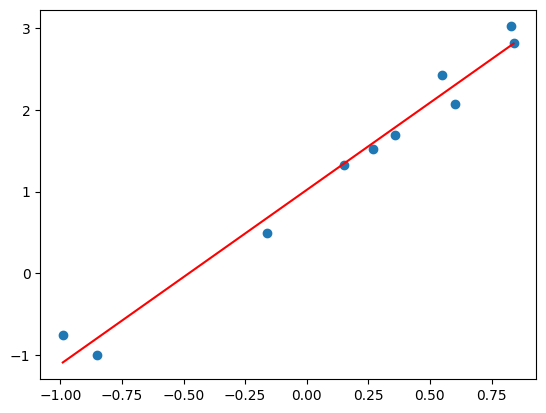

In [8]:
plt.scatter(xs,ys)
plt.plot(xs,pred,c='red')

In [13]:
pd.DataFrame({'xs': xs, 'ys': ys, 'pred': pred, 'err': (ys-pred)**2})

,xs,ys,pred,err
0,-0.99,-0.75,-1.089814,0.115474
1,-0.85,-1.00,-0.791332,0.043542
2,-0.16,0.50,0.679756,0.032312
3,0.15,1.32,1.340680,0.000428
4,0.27,1.52,1.596521,0.005856
5,0.36,1.69,1.788402,0.009683
6,0.55,2.43,2.193485,0.055939
7,0.60,2.07,2.300085,0.052939
8,0.83,3.02,2.790448,0.052694
9,0.84,2.82,2.811768,0.000068


In a supervised setting we have a natural error measure: the difference between input and the output. Our aim is to find the model parameter $\theta$ that makes the total error minimized:

$$ {\rm Err}(\theta) = \sum_{i=1}^N (y^{(i)}_{\rm real} - y^{(i)}_{\rm pred})^2 $$

Remember that the predictions depend on the model parameter $\theta$. We are looking the best $\theta$ that minimizes the error: $ \theta = {\rm argmin}_\theta {\rm Err}(\theta) $

### A New Example: k-Nearest Neighbor

Let $k$ be a fixed positive integer. K-Nearest Neighbors (K-NN) is a non-parametric, instance-based learning algorithm used for classification. It works by assigning the class of the majority of the $k$ nearest neighbors. K-NN does not require training but it stores the entire dataset and computes distances during prediction.

Given a dataset of $N$ points $ X = \{ (x^{(1)}, y_1), (x^{(2)}, y_2), ..., (x^{(n)}, y_n)$ where $x^{(i)}$'s are features and $y_i$'s are the corresponding labels.

For a new query point $x$, the K-NN algorithm follows these steps:

1. Compute the distance between $x$ and every point $x^{(i)}$ in the dataset.
2. Select the k nearest neighbors based on the smallest distances.
3. Assign $x$ the most common class among the neighbors (majority voting):
   $$
   \hat{y} = \arg\max_{c} \sum_{i \in N_k(x)} \mathbb{1}(y_i = c)
   $$

   where $\mathbb{1}(\cdot)$ is the indicator function and $N_k(x)$ is the set of k nearest neighbors.

### The pseudo-code

```plaintext
Input:
    - Training set X = {(x_1, y_1), ..., (x_n, y_n)}
    - Query point x_q
    - Number of neighbors k
    - Distance metric (default: Euclidean)

Output:
    - Predicted labels

Algorithm:
1. Compute the distance between $x$ and each point $x^{(i)}$ in the dataset.
2. Sort the points by increasing distance.
3. Select the k nearest neighbors.
4. Assign the most frequent class among the k neighbors.
5. Return the predicted class.
```

In [14]:
iris = datasets.load_iris()
iris['data']

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
       [4.9, 3

In [15]:
proj = PCA(n_components=2)
projected = proj.fit_transform(iris['data'])
projected

array([[-2.68412563,  0.31939725],
       [-2.71414169, -0.17700123],
       [-2.88899057, -0.14494943],
       [-2.74534286, -0.31829898],
       [-2.72871654,  0.32675451],
       [-2.28085963,  0.74133045],
       [-2.82053775, -0.08946138],
       [-2.62614497,  0.16338496],
       [-2.88638273, -0.57831175],
       [-2.6727558 , -0.11377425],
       [-2.50694709,  0.6450689 ],
       [-2.61275523,  0.01472994],
       [-2.78610927, -0.235112  ],
       [-3.22380374, -0.51139459],
       [-2.64475039,  1.17876464],
       [-2.38603903,  1.33806233],
       [-2.62352788,  0.81067951],
       [-2.64829671,  0.31184914],
       [-2.19982032,  0.87283904],
       [-2.5879864 ,  0.51356031],
       [-2.31025622,  0.39134594],
       [-2.54370523,  0.43299606],
       [-3.21593942,  0.13346807],
       [-2.30273318,  0.09870885],
       [-2.35575405, -0.03728186],
       [-2.50666891, -0.14601688],
       [-2.46882007,  0.13095149],
       [-2.56231991,  0.36771886],
       [-2.63953472,

In [16]:
model = KNeighborsClassifier(n_neighbors=3)
data = model.fit(iris['data'], iris['target'])
pred = model.predict(iris['data'])
pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [17]:
frame = pd.DataFrame(iris['data'], columns=iris['feature_names'])
frame['pred'] = pred
frame['x'] = projected[:,0]
frame['y'] = projected[:,1]
frame

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),pred,x,y
0,5.1,3.5,1.4,0.2,0,-2.684126,0.319397
1,4.9,3.0,1.4,0.2,0,-2.714142,-0.177001
2,4.7,3.2,1.3,0.2,0,-2.888991,-0.144949
3,4.6,3.1,1.5,0.2,0,-2.745343,-0.318299
4,5.0,3.6,1.4,0.2,0,-2.728717,0.326755
...,...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2,1.944110,0.187532
146,6.3,2.5,5.0,1.9,2,1.527167,-0.375317
147,6.5,3.0,5.2,2.0,2,1.764346,0.078859
148,6.2,3.4,5.4,2.3,2,1.900942,0.116628


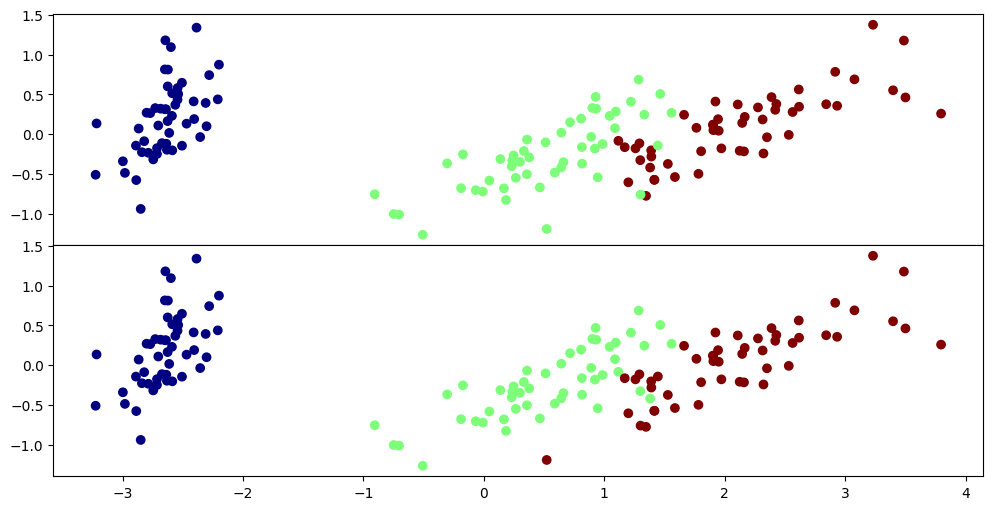

In [18]:
fig = plt.figure(figsize=(12,6))

gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True, sharey=True)

axs[0].scatter(frame['x'], frame['y'], c=frame['pred'], cmap='jet')
axs[1].scatter(frame['x'], frame['y'], c=iris['target'], cmap='jet')

### Did it work?

Visually inspecting the results does not give us a statistical handle on if the model worked. We must find a better way.

#### Confusion matrices:


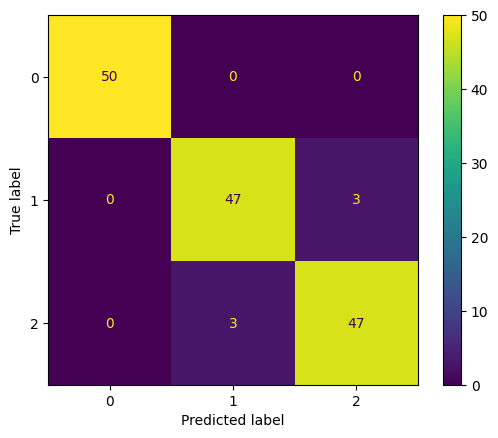

In [19]:
cm = confusion_matrix(iris['target'], frame['pred'])
ConfusionMatrixDisplay(cm).plot()

# Unsupervised Learning

In the unsupervised scheme we don't have input/output pairs, we just have data (input). So, we don't know what we are supposed to get from an input. But we have an *objective*: we want our data do something specific.

## Our First Unsupervised Algorithm: K-Means

K-Means is a partition-based clustering algorithm that seeks to divide a dataset into $ k $ clusters, minimizing the variance within each cluster.


Given a dataset $ X = \{ x_1, x_2, \dots, x_n \} $ where each $ x_i \in \mathbb{R}^d $, the goal is to partition the data into $ k $ disjoint clusters $ C_1, C_2, \dots, C_k $, 

$$
C\colon X\to \{1,\ldots,k\}
$$

where $C_i = C^{-1}(i)$. We will represent each cluster by their centroids $ \mu_1, \mu_2, \dots, \mu_k $, 

$$
\mu_i = \frac{1}{|C_i|} \sum_{x\in C_i} x 
$$

such that the following objective function is minimized:

$$
J = \sum_{i=1}^{k} \sum_{x \in C_i} \| x - \mu_i \|^2
$$

This means each data point is assigned to the closest cluster center, and the sum of squared distances between points and their assigned centroids is minimized.


### The Algorithm

K-Means follows an **iterative refinement** approach:

```
Input: 
    - Dataset X with n data points {x_1, x_2, ..., x_n} in d-dimensional space
    - Number of clusters k
    - Maximum iterations max_iters
    - Convergence threshold tol (optional)

Output:
    - Cluster assignments {c_1, c_2, ..., c_n}
    - Centroids {μ_1, μ_2, ..., μ_k}

Algorithm:
1. Initialize k centroids randomly from the dataset.

2. For each data point x_i:
   - Compute the distance to each centroid μ_j
   - Assign x_i to the nearest centroid:
            c_i = argmin_j ||x_i - μ_j||^2

3. For each cluster C_j compute the new centroid as the mean of assigned points.

4. If ||μ_new - μ_old|| < tol for all j
      Stop
   Else
      Go to Step 3

5. Return the final cluster assignments and centroids.
```

### Convergence Analysis

**Does K-Means converge?**  

The objective function $ J $ decreases monotonically at each iteration.

- In the assignment step (Step 2), each data point is assigned to the nearest centroid, reducing the squared distance $ \| x - \mu_j \|^2 $.
- In the update step (Step 3), recomputing centroids moves them to the mean of assigned points, which is the optimal update under squared Euclidean distance.
- Since there is a finite number of possible cluster assignments, K-Means must converge in a finite number of steps.

However, K-Means may converge to local minima, and its performance depends on initialization.


In [24]:
model = KMeans(n_clusters=3)
pred = model.fit_predict(iris['data'])
pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1,
       1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2], dtype=int32)

In [25]:
frame = pd.DataFrame(iris['data'], columns=iris['feature_names'])
frame['pred'] = pred
frame['x'] = projected[:,0]
frame['y'] = projected[:,1]
frame

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),pred,x,y
0,5.1,3.5,1.4,0.2,0,-2.684126,0.319397
1,4.9,3.0,1.4,0.2,0,-2.714142,-0.177001
2,4.7,3.2,1.3,0.2,0,-2.888991,-0.144949
3,4.6,3.1,1.5,0.2,0,-2.745343,-0.318299
4,5.0,3.6,1.4,0.2,0,-2.728717,0.326755
...,...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,1,1.944110,0.187532
146,6.3,2.5,5.0,1.9,2,1.527167,-0.375317
147,6.5,3.0,5.2,2.0,1,1.764346,0.078859
148,6.2,3.4,5.4,2.3,1,1.900942,0.116628


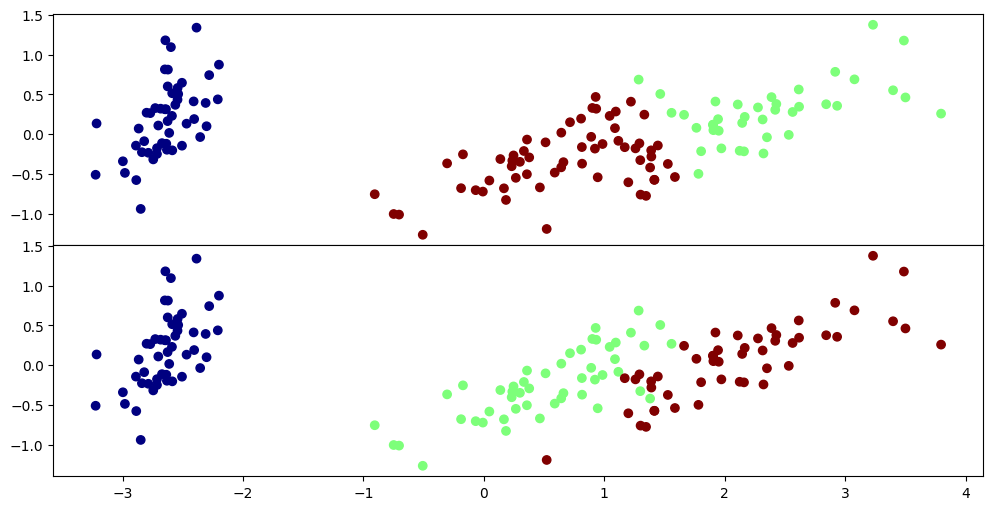

In [26]:
fig = plt.figure(figsize=(12,6))

gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True, sharey=True)

axs[0].scatter(frame['x'], frame['y'], c=frame['pred'], cmap='jet')
axs[1].scatter(frame['x'], frame['y'], c=iris['target'], cmap='jet')

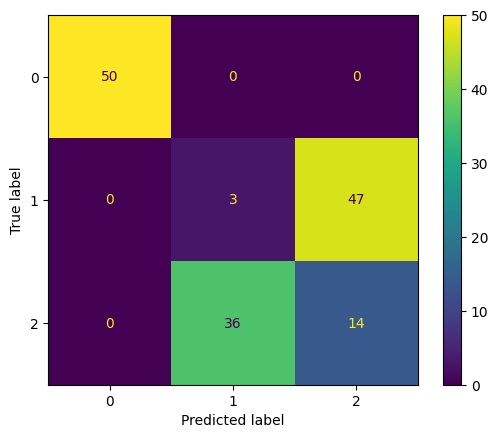

In [28]:
cm = confusion_matrix(iris['target'],frame['pred'])
ConfusionMatrixDisplay(cm).plot()

## Statistic, Tests, Confidence Intervals

Data Science is an experimental science. Like every experimental sciences, it relies on making experiments and observe the results. And like every other experimental science, the experiments are never deterministic: the results always have an indeterminacy baked into them. In other words, the results you observe are **random variables**. We will use statistics to understand and control this randomness

### Law of Large Numbers

Recall that a (continuous) random variable $X$ is defined by a probability density function (PDF) defined on $\mathbb{R}$.
$$ p\colon \mathbb{R}\to [0,\infty) \quad\text{ and }\quad \int_{-\infty}^{\infty} p(x)dx = 1 $$

We will never have access to the PDF. Only thing we can do is to repeat the experiment and make a finite sample of measurements. 

$$ X_1,\ldots,X_N \quad \text{ where } X_i \sim p(x) $$

Our measurements is done via a function $f(x)$ and we will be interested in 

$$ \mathbb{E}(f(x)) = \int_{-\infty}^\infty f(x) p(x) dx $$

At this point Law of Large Numbers come in: If the size of the sample is large enough, the average of $f(X_i)$'s approximate the expected value of $f(X)$. In other words,

$$ \mathbb{E}(f(X)) \approx \frac{1}{N} \left( f(X_1) + \cdots + f(X_N) \right) $$

### Central Limit Theorem

OK. We can approximate the expected value. But how sure are we going to be that this number is correct. This is where the Central Limit Theorem comes in:

The sample average $\overline{f(X)}$ is a Gaussian random variable with mean $\mathbb{E}(f(X))$ and variance ${\rm Var}(X)/N$.

### An Example

Assume you are working for a financial institution. Specifically, you'll be working in the [factoring department](https://en.wikipedia.org/wiki/Factoring_(finance)). Your job is to develop a model for distinguishing customers as *acceptible* or *non-acceptable*. Assume you can test your model on past data and calculate its accuracy. Assume you repeated the experiment on different datasets and calculated the accuracy as


In [9]:
accuracy = np.array([80, 75, 91, 85, 72, 93, 87])
N = len(accuracy)
mean = accuracy.mean()
var = np.var(accuracy, ddof=1)  
dev = np.sqrt(var)
N, mean, dev

(7, np.float64(83.28571428571429), np.float64(7.931252228038263))

Using the Central Limit Theorem, we can determine that with 95% certainity that the accuracy is 83.3% plus/minus the error:

In [10]:
st_err = dev / np.sqrt(N)
z_score = stats.norm.ppf(0.975)

margin = z_score * st_err
margin

np.float64(5.875445909919292)

But, here is the problem: $N=7$ is not large enough and we don't know the real variance of the population. So, instead of the normal distribution we must use the $t$-distribution with $N-1=6$ degrees of freedom:

In [11]:
df = N - 1
t_score = stats.t.ppf((1 + 0.95) / 2, df)

margin = t_score * st_err
margin

np.float64(7.335184901939176)

So model is 83.3% accurate with an error of $\pm$ 7.3%.

### Unpaired t-tests

OK. Let us assume you redesigned the model and performed another bunch of tests to observe:

In [12]:
accuracy = np.array([80, 75, 91, 85, 72, 93, 87])
new_accuracy = np.array([90, 88, 85, 82, 91, 86])
N = len(new_accuracy)
mean = new_accuracy.mean()
var = np.var(new_accuracy, ddof=1)  
dev = np.sqrt(var)
N, mean, dev

(6, np.float64(87.0), np.float64(3.3466401061363023))

In [6]:
t_score = stats.t.ppf((1 + 0.95) / 2, df)

margin = t_score * st_err
margin

np.float64(7.335184901939176)

Is there a difference between earlier results and this one?

In [7]:
stats.ttest_ind(accuracy, new_accuracy)

TtestResult(statistic=np.float64(-1.0635694431715539), pvalue=np.float64(0.31031468529809153), df=np.float64(11.0))

### Paired t-test

We use t-test to see if there is a difference between averages of samples. If we take the samples from the same processes, we can compare them invidually and see if the averages differ.

Assume we give a credit scores to each of our customers. We have two different models and the scores are


In [8]:
scores1 = [90, 66, 99, 10, 40, 80, 90]
scores2 = [98, 65, 98, 32, 45, 99, 99]
stats.ttest_rel(scores1,scores2)

TtestResult(statistic=np.float64(-2.5632665666031627), pvalue=np.float64(0.042720388461096916), df=np.int64(6))